In [1]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit
import statsmodels.formula.api as smf

# Import et préparation des données

In [2]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [3]:
train_prepared = pd.read_csv("../data/train_prepared.csv", index_col=[0])
test_prepared = pd.read_csv("../data/test_prepared.csv", index_col=[0])

In [7]:
dataprep = DataPreparation(train, test, 0.3)
train_prepared, test_prepared = dataprep.get_prepared_data()

Type des variables convertis ✅


KeyboardInterrupt: 

In [4]:
df_train = train_prepared.copy()

In [5]:
df_train["TARGET"] = df_train["TARGET"].astype("int")

In [6]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

# Modélisation

In [7]:
features = list(df_train.iloc[:,2:7].columns)

In [8]:
formula = f'TARGET ~ {" + ".join(f"C({var})" for var in features)}'

In [9]:
reference_categories = {var : df_train[var].mode()[0] for var in features}

In [10]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')
    else:
        formula_parts.append(f'C({var})')  # Ou simplement 'var' si c'est une variable continue

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [11]:
model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2538339716351152
            Iterations: 67
            Function evaluations: 67
            Gradient evaluations: 67


# Prédiction

In [12]:
pred = logit_model.predict(df_validation[features])

In [13]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


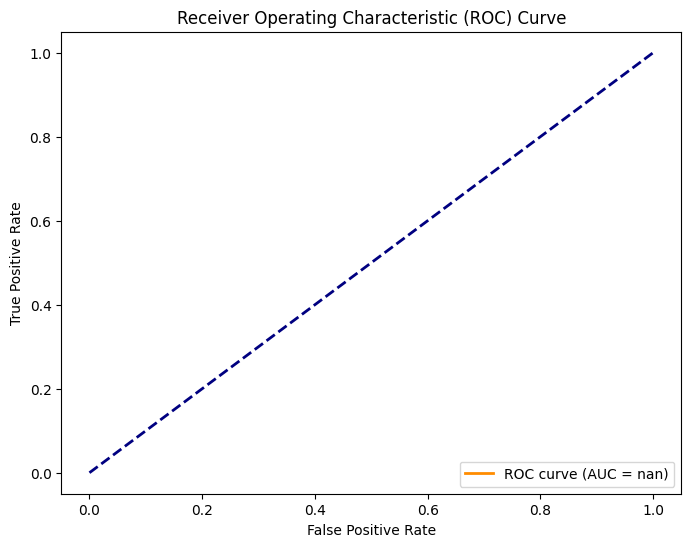

In [14]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

nan

# Grille de score

In [16]:
GridScore(df_train, logit_model).compute_grid_score()

Variable                Modality  Coefficient  \
0                    Intercept                       -    -2.584353   
1          DAYS_BIRTH_disc_int     [-19590;-13345]_ref     0.000000   
2          DAYS_BIRTH_disc_int          [-13344;-7489]     0.130000   
3          DAYS_BIRTH_disc_int         [-25229;-19591]    -0.470000   
4        EXT_SOURCE_2_disc_int         [0.51;0.85]_ref     0.000000   
5        EXT_SOURCE_2_disc_int              [0.0;0.15]     1.400000   
6        EXT_SOURCE_2_disc_int             [0.15;0.51]     0.660000   
7        EXT_SOURCE_1_disc_int           [0.0;0.4]_ref     0.000000   
8        EXT_SOURCE_1_disc_int              [0.4;0.67]    -0.470000   
9        EXT_SOURCE_1_disc_int             [0.67;0.96]    -0.840000   
10    AMT_GOODS_PRICE_disc_int  [40500.0;676278.0]_ref     0.000000   
11    AMT_GOODS_PRICE_disc_int    [679500.0;4050000.0]    -0.320000   
12  DAYS_REGISTRATION_disc_int       [-5725.0;0.0]_ref     0.000000   
13  DAYS_REGISTRATION_disc_int      [-24672.0;-5726.0]    -0.130000   

    Contribution  P-Value  Normalized Score  Pcentage_Défaut  Pcentage_Classe  
0            0.0      0.0              0.00             0.00             0.00  
1           20.0      0.0              0.00             3.10            42.80  
2           20.0      0.0            567.52             3.18            31.49  
3           20.0      0.0            835.03             1.28            25.71  
4            9.0      0.0              0.00             3.07            61.19  
5            9.0      0.0              1.27             1.17             5.86  
6            9.0      0.0            331.21             3.31            32.95  
7           30.0      0.0              0.00             6.26            71.58  
8           30.0      0.0            835.03             0.94            16.95  
9           30.0      0.0           1000.00             0.35            11.48  
10          22.0      0.0              0.00             6.16            73.77  
11          22.0      0.0            768.16             1.40            26.23  
12          19.0      0.0              0.00             5.16            62.09  
13          19.0      0.0            683.44             2.40            37.91